In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather[item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

In [3]:
# for c in weather.columns:
#     print(c)
#     print (weather[c].value_counts())

In [4]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', 0)
weather = weather.replace('T', 0)
weather = weather.replace(' T', 0)
weather = weather.replace('  T', 0)

In [5]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)

In [6]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [7]:
# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')

# train = train.merge(spray, on='Date')
# test = test.merge(spray, on='Date')

In [8]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0

        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=2) :

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):

                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)

                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 10 and cur_lat > spray_lat - 10) and \
                    (cur_long < spray_long + 10 and cur_long > spray_long - 10):
                        data_df.set_value(r,col_name, 1)
                        break

In [9]:
create_sprayed_cols(train, spray, time_period=10)
create_sprayed_cols(test,spray, time_period=10)

In [10]:
#Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

train = pd.get_dummies(train, prefix = ['Trap', 'Species'],\
                                      columns=['Trap','Species'],drop_first=True)
test = pd.get_dummies(test, prefix = ['Trap', 'Species'],\
                                     columns=['Trap','Species'], drop_first=True)


In [11]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [12]:
train = train.drop('Date', axis=1)
test = test.drop('Date', axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

In [13]:
_ = train.convert_objects(convert_numeric=True)
_ = test.convert_objects(convert_numeric=True)

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


# Grid searching below

In [14]:
n_estimators = [50,300,1000]
criterion = ['entropy']
max_depth = [2,3,5,10,12]
min_samples_split = [2,5,7,10]
max_features = [5,10,20,55,50,60]
clf = ensemble.GradientBoostingClassifier()

In [15]:
# Random Forest Classifier 
grid = model_selection.GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators,
                                                    max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split))

grid.fit(train,labels)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 7, 10], 'max_features': [5, 10, 20, 55, 50, 60], 'n_estimators': [50, 300, 1000], 'max_depth': [2, 3, 5, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Evaluating results

In [16]:
grid.best_estimator_.fit(train, labels)

# create predictions and submission file
predictions = grid.best_estimator_.predict_proba(test)[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)

In [17]:
grid.best_score_

0.73999273534403121

In [18]:
sum(labels)/float(len(labels))

0.052446221206929371

In [19]:
np.mean(model_selection.cross_val_score(grid.best_estimator_, X=train, y=labels, scoring='roc_auc', n_jobs=7))

0.70865034275177174

In [20]:
model = grid.best_estimator_


#### Looking at feature importances

Feature ranking:
Longitude: 0.0552594189699
Sunrise_x: 0.0538075165102
year: 0.049166870573
Sunset_x: 0.0476920544263
ResultSpeed_x: 0.0375721376172
Street: 0.0319094272293
Latitude: 0.026767865715
ResultDir_x: 0.0262586133865
Tmin_y: 0.0237769321595
WetBulb_y: 0.0217020693562
ResultDir_y: 0.0215201984324
StnPressure_y: 0.0194404583589
StnPressure_x: 0.0186511874252
TS_x: 0.0162342733553
Species_3: 0.0156173452624
Depart_x: 0.015252143194
DewPoint_y: 0.0146800133804
Species_6: 0.0145960610555
Trap_80: 0.0144022777818
Trap_133: 0.0142290100574
month: 0.0129726423617
Trap_13: 0.0123854807614
Tmin_x: 0.0123428900535
DewPoint_x: 0.0121806096911
Tavg_y: 0.0116712463119
Trap_4: 0.0115444415481
Cool_x: 0.0112610776911
Block: 0.0102903322631
spray_2013-09-05_10: 0.0102213217244
Trap_143: 0.0101390411131
PrecipTotal_y: 0.010031236943
Trap_1: 0.0100154797584
Trap_22: 0.00998712025101
spray_2013-08-29_10: 0.00997088360986
SeaLevel_y: 0.00964789125627
spray_2013-08-15_10: 0.00939457330068
ResultSp

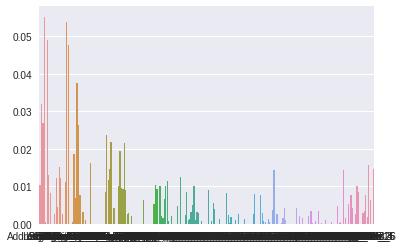

In [21]:
# Zipping feature importances and sorting by how importnat they are
importances = zip(train.columns,model.feature_importances_)
importances.sort(key=lambda x: x[1])
importances = importances[::-1]
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [22]:
grid.best_params_

{'max_depth': 2,
 'max_features': 50,
 'min_samples_split': 5,
 'n_estimators': 300}